In [ ]:
import numpy as np
import random
import pandas as pd
from  matplotlib import pyplot as plt
import codecs
from gensim.models import KeyedVectors
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from scipy.sparse import hstack, csr_matrix, vstack

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Calculate sentence embedding

In [ ]:
def get_char_vector(s, wv):
    default_emb = np.zeros((400, ))
    vecs = []
    for c in s:
        vecs.append(wv[str(c)] if c in wv.vocab.keys() else default_emb)
    return np.mean(vecs, axis=0)

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, model):
        self.model = model
        self.dim = len(model.vocab)
        self.default_emb = np.zeros((400, ))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
                np.mean([self.model[w] 
                         if w in self.model.vocab.keys() 
                         else get_char_vector(w, self.model) 
                         for w in words.split(" ")], axis=0) if words != "" else self.default_emb for words in X])
    

In [ ]:
model = KeyedVectors.load_word2vec_format("/content/drive/My Drive/vlsp/baomoi.model.bin", binary=True)

In [ ]:
model.most_similar(positive=["cán_bộ"])

[('cbcc', 0.5781417489051819),
 ('cbcĐ', 0.5512620210647583),
 ('cbcs', 0.534953773021698),
 ('cán_bộ_chính_trị', 0.5315697193145752),
 ('cán_bộ_chỉ_huy', 0.5292246341705322),
 ('viên_chức', 0.5175833702087402),
 ('công_tác', 0.5019720792770386),
 ('nhân_viên', 0.501397967338562),
 ('lãnh_đạo', 0.4960173964500427),
 ('giáo_viên', 0.48895594477653503)]

In [ ]:
len(model.vocab)

439056

# Load data

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/vlsp/clean_train_df_ext.csv")
test_df = pd.read_csv("/content/drive/My Drive/vlsp/clean_final_test_df.csv")

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1646 non-null   int64  
 1   user_name           1646 non-null   object 
 2   timestamp_post      1646 non-null   float64
 3   num_like_post       1646 non-null   float64
 4   num_comment_post    1646 non-null   float64
 5   num_share_post      1646 non-null   float64
 6   len_post_message    1646 non-null   int64  
 7   clean_post_message  1646 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 103.0+ KB


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5172 non-null   int64  
 1   user_name           5172 non-null   object 
 2   timestamp_post      5172 non-null   float64
 3   num_like_post       5172 non-null   float64
 4   num_comment_post    5172 non-null   float64
 5   num_share_post      5172 non-null   float64
 6   label               5172 non-null   int64  
 7   clean_post_message  5102 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 323.4+ KB


In [ ]:
train_df['clean_post_message'].fillna("", inplace=True)
test_df['clean_post_message'].fillna("", inplace=True)

In [ ]:
train_df['clean_post_message'].values

array(['Cần các bậc phụ_huynh xã Ngũ_Thái lên_tiếng , không ngờ xã mình cũng nhận thịt nhiễm sán ... Cho các cháu Mầm_non ăn_uống thế_này thật vô_nhân tính ! VTV đăng tin rồi nhé các anh_chị .',
       'KÊU_GỌI ĂN_CHAY CẦU_NGUYỆN XIN CHÚA CỨU KHỎI DỊCH VIRUS CORONA',
       'Giàn khoan dầu_khí gặp sự_cố , chết người ! Giàn khoan dầu_khí ngoài_trời Vũng_Tàu gặp sự_cố , làm chết nhiều người . Được biết nguyên_nhân gây ra sự_cố này là do gặp phải khí độc bốc lên làm nhiều người ngạt khí .',
       ...,
       'Lời cảnh_tỉnh cho các thanh_niên dân TỔ ... tốc_độ bàn_thờ là có thật mặt la_hét kinh_hãi - - hậu_quả là 1 cái c.h.ế.t vắt x.á.c , th.i t.h.ể Ko còn nguyên vẹnmặt sợ hãimặt sợ hãimặt sợ_hãi ải Bát_hương Vàng có chủ',
       'Đến bây_giờ mới biết chỉ cần học lái_xe hạng B2 là biết chữa bá bệnh cho người và còn làm lãnh_đạo y_tế nữa . Đúng là chuyện ở xứ thiên_đường !',
       'Tư_lệnh ngành cấm bay với phi_công Pakistan , rà_soát bằng_cấp các phi_công nước_ngoài . Cục hàng_không nhan

In [ ]:
train_df['clean_post_message'] = train_df['clean_post_message'].astype(str)
test_df['clean_post_message'] = test_df['clean_post_message'].astype(str)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5172 non-null   int64  
 1   user_name           5172 non-null   object 
 2   timestamp_post      5172 non-null   float64
 3   num_like_post       5172 non-null   float64
 4   num_comment_post    5172 non-null   float64
 5   num_share_post      5172 non-null   float64
 6   label               5172 non-null   int64  
 7   clean_post_message  5172 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 323.4+ KB


In [ ]:
train_df['clean_post_message'].apply(lambda x: len(x.split(" "))).max()

5044

In [ ]:
t = MeanEmbeddingVectorizer(model)
X_train = t.transform(train_df['clean_post_message'].values)

In [ ]:
X_test = t.transform(test_df['clean_post_message'].values)

In [ ]:
X_train.shape

(5172, 400)

In [ ]:
y_train = train_df['label'].values

In [ ]:
y_train.shape

(5172,)

In [ ]:
X_train = np.nan_to_num(X_train, nan=-999)
X_test = np.nan_to_num(X_test, nan=-999)

# CV to choose C

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
10. ** np.arange(-2, 2)

array([ 0.01,  0.1 ,  1.  , 10.  ])

In [ ]:
Cs = 10. ** np.arange(-2, 2)
y_test_pred = np.zeros((1646, ), dtype=np.float64)
history = []
for C in Cs:
  print("C ", C)
  kf = KFold(n_splits=5, shuffle=True)

  for (i, (train_idx, val_idx)) in enumerate(kf.split(X_train)):
      X_train_kf, X_val_kf = X_train[train_idx], X_train[val_idx]
      y_train_kf, y_val_kf = y_train[train_idx], y_train[val_idx]

      clf = make_pipeline(StandardScaler(with_mean=False), SVC(C = C, gamma='auto', probability=True))
      clf.fit(X_train_kf, y_train_kf)

      y_pred = clf.predict_proba(X_val_kf)[:, 1]

      y_test_pred += clf.predict_proba(X_test)[:, 1]

  #     print(y_val_kf)
  #     print(y_pred[:, 1])

      roc_score = roc_auc_score(y_val_kf, y_pred)
      print("Fold ", i, ": ", roc_score)
  # history.append(t_roc_score/5.0)

C  0.01
Fold  0 :  0.8413034796387668
Fold  1 :  0.8603571788921401
Fold  2 :  0.8889062110251934
Fold  3 :  0.8632425135002455
Fold  4 :  0.8800787600474114
C  0.1
Fold  0 :  0.8701040669711544
Fold  1 :  0.8814630141375306
Fold  2 :  0.8570576239511583
Fold  3 :  0.8800942128220735
Fold  4 :  0.8775692192566724
C  1.0
Fold  0 :  0.8931063743556621
Fold  1 :  0.9037581147510225
Fold  2 :  0.9133519063096528
Fold  3 :  0.88733589859665
Fold  4 :  0.8713690867537022
C  10.0
Fold  0 :  0.8797685933451346
Fold  1 :  0.8630105968662259
Fold  2 :  0.8869248628113129
Fold  3 :  0.9042243609251369
Fold  4 :  0.9019479155728236


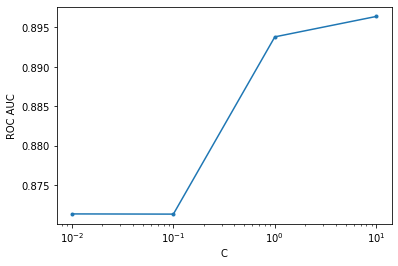

In [ ]:
# plt.axes.set_xscale('log')
# plt.plot(Cs, history)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('C')
ax.set_ylabel('ROC AUC')
ax.plot(Cs, history, '.-')

Still use C = 1 because C = 10 doesn't improve much

In [ ]:
y_test_pred = np.zeros((1646, ), dtype=np.float64)
history = []
kf = KFold(n_splits=5)
for (i, (train_idx, val_idx)) in enumerate(kf.split(X_train)):
    X_train_kf, X_val_kf = X_train[train_idx], X_train[val_idx]
    y_train_kf, y_val_kf = y_train[train_idx], y_train[val_idx]

    clf = make_pipeline(StandardScaler(with_mean=False), SVC(C = 1, gamma='auto', probability=True))
    clf.fit(X_train_kf, y_train_kf)

    y_pred = clf.predict_proba(X_val_kf)[:, 1]

    y_test_pred += clf.predict_proba(X_test)[:, 1]

    roc_score = roc_auc_score(y_val_kf, y_pred)
    history.append(roc_score)
    print("Fold ", i, ": ", roc_score)

Fold  0 :  0.9308648978412337
Fold  1 :  0.8856492750555615
Fold  2 :  0.8985010808210173
Fold  3 :  0.8745567128120091
Fold  4 :  0.879843350496221


In [ ]:
print(np.array(history).mean(), "+-", np.sqrt(np.array(history).var()))

0.8938830634052085 +- 0.02013652800018478


In [ ]:
y_test_pred = y_test_pred/5

In [ ]:
y_test_pred

array([0.03355276, 0.02033318, 0.01110759, ..., 0.00494078, 0.01113427,
       0.03732888])

In [ ]:
result = pd.DataFrame()
result['id'] = test_df['id']
result['label'] = y_test_pred

In [ ]:
result.to_csv('results.csv', index=False, header=None)

# Stacking part

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_strain, X_sval, y_strain, y_sval = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

In [ ]:
clf = make_pipeline(StandardScaler(with_mean=False), SVC(C = 1, gamma='auto', probability=True))
clf.fit(X_strain, y_strain)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
y_sval_pred = clf.predict_proba(X_sval)[:, 1]
y_test_pred = clf.predict_proba(X_test)[:, 1]

In [ ]:
pd.DataFrame(y_sval_pred, columns=["y_sval_pred_svm"]).to_csv('y_sval_pred_svm.csv', index=False)
pd.DataFrame(y_test_pred, columns=["y_test_pred_svm"]).to_csv('y_test_pred_svm.csv', index=False)

In [ ]:
y_sval

array([0, 0, 0, ..., 1, 1, 0])